In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch
from tqdm import tqdm 

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
from models.last_layer_models import LLI, train_last_layer_det, LastLayerVIClosedForm
from models.vi import fit_vi_post_hoc, fit_vi_post_hoc
from utils.data_utils import create_synthetic_train_data
from models.vi import fit_vi_post_hoc, fit_vi_post_hoc

np.random.seed(100)

## old

Text(0.5, 1.0, 'Training/Validation split')

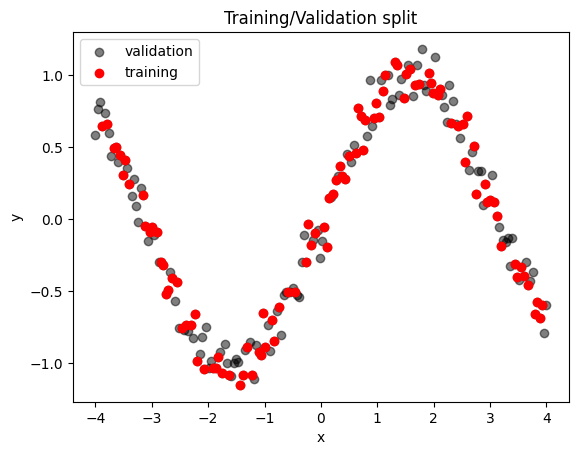

In [2]:
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = 0.1)

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

In [3]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 10, 1]
num_epochs = 100
lli_net = LLI(model_dims)
sigma_0 = 0.1

100%|██████████| 100/100 [00:00<00:00, 176.13it/s]


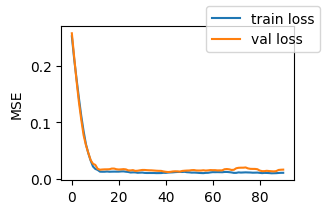

In [4]:
# train deep feature projector psi
lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)

lli_net.eval()

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [5]:
with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

for param in lli_net.parameters():
    param.requires_grad = False

In [18]:
sigma_eps_sq = torch.tensor(0.1, dtype=torch.float32)   # fixed observational noise
sigma_0_sq   = torch.tensor(10.0, dtype=torch.float32)  # isotropic prior for w

post_lambdas, elbos = fit_vi_post_hoc(ys = ys_train.detach(), 
                               Psi = Psi.detach(), lr = 1e-2, 
                               num_iter = 10000, sigma_eps_sq = sigma_eps_sq, 
                               sigma_0_sq = torch.tensor(.1), 
                               mu_0 = lli_net.last_layer.weight.detach().squeeze(),
                               method = 'closed_form')

100%|██████████| 10000/10000 [00:02<00:00, 3617.16it/s]


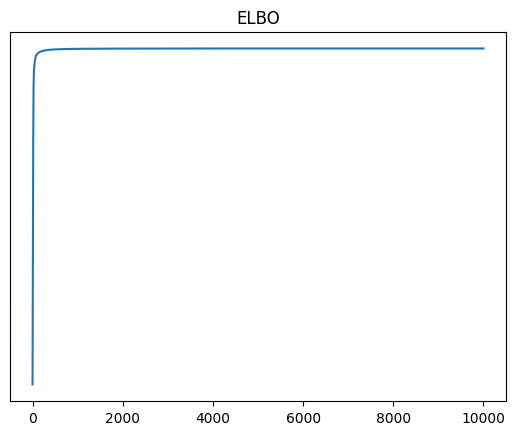

In [19]:
fig, axs = plt.subplots(1,1)
axs.plot(elbos)
axs.set_title('ELBO')
plt.yscale('symlog')

In [20]:
post_lambdas['mu']

tensor([ 0.0008,  0.0002,  0.0000, -0.0004, -0.0005, -0.0006, -0.0001, -0.0024,
        -0.0006,  0.0014])

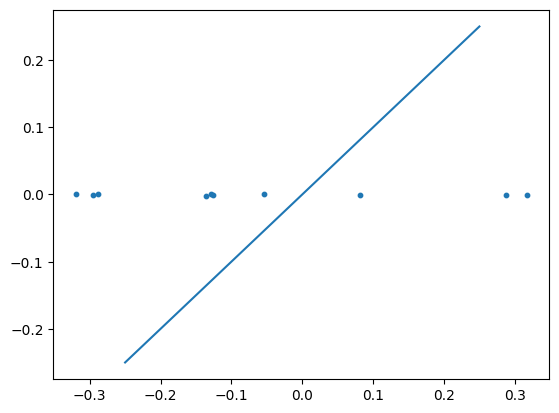

In [21]:
plt.scatter(lli_net.last_layer.weight.detach().numpy(), post_lambdas['mu'], s = 10)
plt.plot([-.25,.25], [-.25,.25])

In [10]:
def predictive_posterior(psi, mu_w, sigma_eps_sq, Sigma_w, ys_grid):
    p_hats = []
    for y in ys_grid:
        log_prob = get_log_likelihood_closed_form(ys = y, 
                                    Psi = psi,
                                    mu_w = mu_w,  
                                    sigma_eps_sq = sigma_eps_sq,
                                    Sigma_w = Sigma_w,
                                    N = 1
                                    )
        p_hats.append(torch.exp(log_prob))
    
    p_hats = torch.stack(p_hats) 
    y_mean = torch.trapz(p_hats*ys_grid,ys_grid)
    mean_sq_i = torch.trapz(p_hats * ys_grid**2, ys_grid)
    y_var = mean_sq_i - y_mean**2
    
    return {'p_hats': p_hats, 
            'y_mean': y_mean, 
            'y_var': y_var}

In [11]:
ys_grid = np.arange(-5,5, 0.01)
pred_post = [predictive_posterior(psi = Psi[i], mu_w = post_lambdas['mu'].detach(), 
                      sigma_eps_sq = sigma_eps_sq, 
                      Sigma_w = torch.eye(Psi.shape[1]), ys_grid = torch.tensor(ys_grid)) for i in tqdm(range(len(ys_train)))]


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/clarahoffmann/Documents/code/last_layer_inference/last-layer-inf/src/models/vi.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  var_component = 0.5 * (1.0 / sigma_eps_sq) * (Psi @ Sigma_w @ Psi.T)
100%|██████████| 100/100 [00:02<00:00, 38.04it/s]


In [12]:
ys_grid = np.arange(-5,5, 0.01)
pred_post = [predictive_posterior(psi = Psi[i], mu_w = lli_net.last_layer.weight.detach().numpy().squeeze(), 
                      sigma_eps_sq = sigma_eps_sq, 
                      Sigma_w = torch.eye(Psi.shape[1]), ys_grid = torch.tensor(ys_grid)) for i in tqdm(range(len(ys_train)))]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 22.80it/s]


In [13]:
p_hats = torch.stack([d['p_hats'] for d in pred_post])
y_means = torch.stack([d['y_mean'] for d in pred_post])
y_vars = torch.stack([d['y_var'] for d in pred_post])

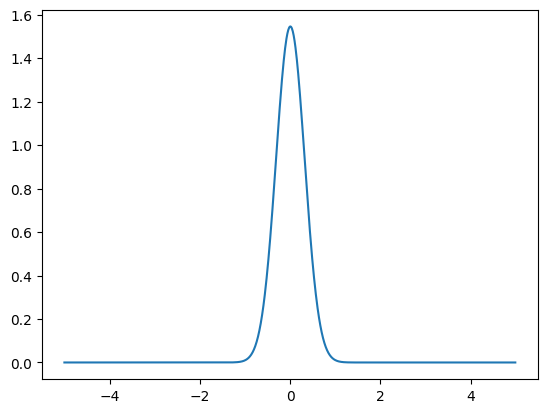

In [14]:
plt.plot(ys_grid, p_hats[0,:])

In [15]:
#lli_vi_pred_mu, lli_vi_pred_var = predictive_posterior(Psi =Psi, 
#                                                       mu = post_lambdas['mu'], 
#                                                       sigma = post_lambdas['sigma'], 
#                                                       sigma_eps_sq = sigma_eps_sq)
#lli_vi_pred_std = np.sqrt(lli_vi_pred_var)

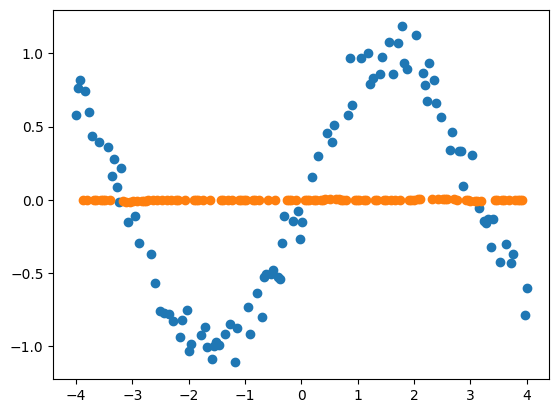

In [16]:
plt.scatter(xs_val, ys_val)
plt.scatter(xs_train, y_means)

# New try

In [2]:
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = 0.3)
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 10, 1]
num_epochs = 100

In [3]:
from torch import nn
from torch.optim import Adam

lli_net = LLI(model_dims)
    
params = list(lli_net.parameters())

model, losses_train, losses_val = train_last_layer_det(model = lli_net, dataloader_train = dataloader_train,
                     dataloader_val= dataloader_train, weight_decay = 0, num_epochs = 100)


for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)



100%|██████████| 100/100 [00:00<00:00, 128.40it/s]


In [4]:
last_layer_vi = LastLayerVIClosedForm(dim_last_layer=Psi.shape[1], dim_output=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-2)
num_epochs = 10000
sigma_eps_sq = 0.1**2

elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    pred_y_mu= last_layer_vi.forward_det(Psi)
    
    L = last_layer_vi.get_L().squeeze()
    Sigma_w = L @ L.T

    kl = last_layer_vi.kl_divergence()

    log_likelihood = (-0.5 * Psi.shape[0] * torch.log(2 * torch.pi * torch.tensor(sigma_eps_sq)) \
        - 0.5  * torch.sum((ys_train - pred_y_mu) ** 2 / sigma_eps_sq) \
            - 0.5 *( torch.diagonal(Psi @ Sigma_w @ Psi.T).sum())/ sigma_eps_sq)
    
    elbo = (
        log_likelihood
        - kl
    )
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    if epoch % 100 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f} \n 'log likelihood: {log_likelihood.item():.3f}")

    elbos.append(elbo.item())


VI epoch 0 ELBO: -28550.857 
 'log likelihood: -28550.188
VI epoch 100 ELBO: -2799.657 
 'log likelihood: -2799.070
VI epoch 200 ELBO: -1306.409 
 'log likelihood: -1305.265
VI epoch 300 ELBO: -868.463 
 'log likelihood: -866.844
VI epoch 400 ELBO: -689.146 
 'log likelihood: -687.112
VI epoch 500 ELBO: -589.233 
 'log likelihood: -586.821
VI epoch 600 ELBO: -520.771 
 'log likelihood: -518.002
VI epoch 700 ELBO: -469.530 
 'log likelihood: -466.414
VI epoch 800 ELBO: -429.960 
 'log likelihood: -426.501
VI epoch 900 ELBO: -398.937 
 'log likelihood: -395.139
VI epoch 1000 ELBO: -374.318 
 'log likelihood: -370.182
VI epoch 1100 ELBO: -354.551 
 'log likelihood: -350.080
VI epoch 1200 ELBO: -338.498 
 'log likelihood: -333.697
VI epoch 1300 ELBO: -325.324 
 'log likelihood: -320.197
VI epoch 1400 ELBO: -314.396 
 'log likelihood: -308.950
VI epoch 1500 ELBO: -305.484 
 'log likelihood: -299.724
VI epoch 1600 ELBO: -297.521 
 'log likelihood: -291.455
VI epoch 1700 ELBO: -290.938 
 'log

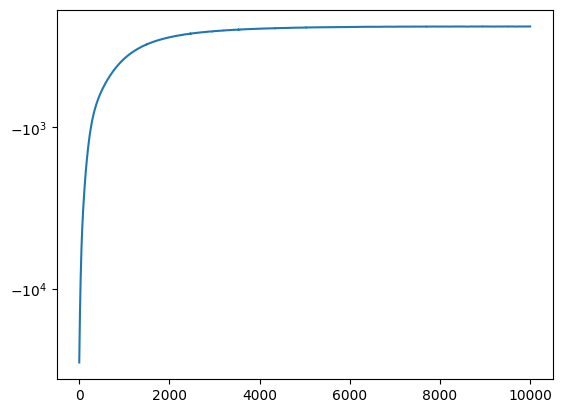

In [5]:
plt.plot(elbos)
plt.yscale('symlog')

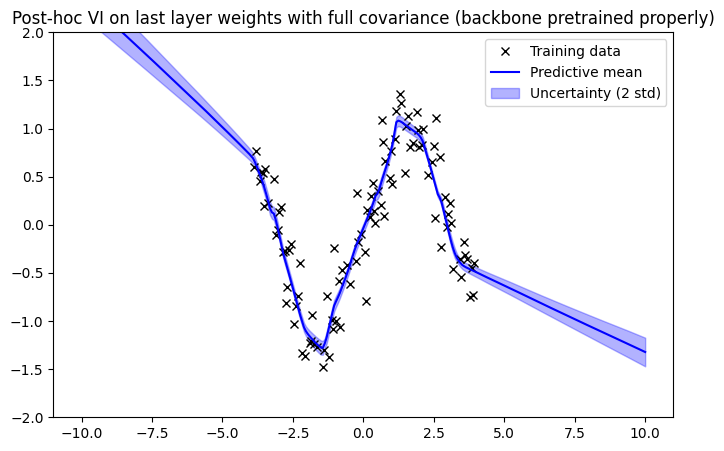

In [6]:

# Plot
last_layer_vi.eval()
with torch.no_grad():
    X_test = torch.linspace(-10,10, 300).unsqueeze(1)
    features_test = lli_net.get_ll_embedd(X_test)
    preds_samples = []
    for _ in range(100):
        preds, _ = last_layer_vi.forward_sample(features_test)
        preds_samples.append(preds.squeeze())
    preds_samples = torch.stack(preds_samples)
    mean_pred = preds_samples.mean(dim=0)
    std_pred = preds_samples.std(dim=0)

plt.figure(figsize=(8,5))
plt.ylim(-2,2)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), mean_pred.numpy(), 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 mean_pred.numpy() - 2 * std_pred.numpy(),
                mean_pred.numpy() + 2 * std_pred.numpy(),
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance (backbone pretrained properly)")
plt.show()


# Ridge

In [4]:
from scipy.special import gammaln

In [5]:
def get_h_params_ridge(ys: torch.Tensor, 
                            Psi: torch.Tensor,
                            mu_w: torch.Tensor,  
                            tau_sq: torch.Tensor,
                            sigma_eps_sq: torch.Tensor, 
                            nu: float,
                            a_sigma: float,
                            b_sigma: float,
                            L: int,
                            N: int) -> torch.Tensor:

    term1 = log_p_y_cond_w_sigma_sq(Psi, mu_w, ys, sigma_eps_sq, tau_sq, N)
    term2 = log_p_w_cond_tau_sq(mu_w, tau_sq, L)
    term3 = log_p_tau_sq(tau_sq, nu)
    term4 = log_p_sigma_eps_sq(sigma_eps_sq, a_sigma, b_sigma)

    #print(term1, term2, term3, term3)

    return term1  #+ term2  + term4 + term3

def log_p_y_cond_w_sigma_sq(Psi, mu_w, ys, sigma_eps_sq, tau_sq, N):
    """Log of p(y | x, w, sigma_eps_sq) for the ridge prior (log-likelihood)."""
    pred_y = Psi @ mu_w
    log_likelihood = (
        - 0.5 * N * torch.log(sigma_eps_sq) 
        - 0.5 * (torch.sum((ys - pred_y) ** 2)/ sigma_eps_sq)
    )
    
    return log_likelihood

def log_p_w_cond_tau_sq(w, tau_sq, L):
    """Log of p(w|tau^2) for the ridge prior."""
    return - .5*torch.sum(w**2/tau_sq) - .5*L*math.log(2*math.pi) - 0.5*L*torch.log(tau_sq)

def log_p_tau_sq(tau_sq, nu):
    """Log-density of the scale-dependent prior of Klein, Kneib 2016"""
    return -.5*torch.log(tau_sq) + .5*math.log(nu) - torch.sqrt(tau_sq/nu)

def log_p_sigma_eps_sq(sigma_eps_sq, a_sigma, b_sigma):
    log_prob1 = (a_sigma * math.log(b_sigma) - gammaln(a_sigma))
    log_prob2 = - (a_sigma + 1) * torch.log(sigma_eps_sq) - b_sigma / sigma_eps_sq
    return log_prob1 +log_prob2

In [6]:
for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)


class LastLayerVI(nn.Module):
    def __init__(self, in_features, out_features, prior_var=.3):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.prior_var = prior_var
        self.prior_cov = torch.eye(in_features) * prior_var
        self.prior_cov_inv = torch.inverse(self.prior_cov)
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_tau_sq = nn.Parameter(torch.ones(out_features, 1))
        self.log_sigma_eps_sq = nn.Parameter(torch.ones(out_features, 1))

        self.Sigma_q_unconstrained = nn.Parameter(torch.randn(out_features, in_features + 2) * 0.01)
    
    def get_tau_sq(self):
        return torch.nn.functional.exp(self.log_tau_sq)
    
    def get_sigma_eps_sq(self):
        return torch.nn.functional.exp(self.log_sigma_eps_sq)

    def get_Sigma_q(self):
        Sigma_q = torch.nn.functional.softplus(self.Sigma_q_unconstrained) + 1e-5
        return Sigma_q
    
    def forward(self, X, S = 5):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        Sigma_q = self.get_Sigma_q()
        params_samples = params + L*eps

        y_sample = X @ params_samples[:, :self.in_features].t()
        
        return params_samples, params, y_sample, Sigma_q
    
    def forward_sample(self, X, S = 1):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        L = self.get_Sigma_q()
        params_samples = params + L*eps
        w_sample = params_samples[:, :self.in_features]

        y_sample = X @ w_sample.T # variance is missing here
        
        return y_sample

In [69]:
last_layer_vi = LastLayerVI(in_features=Psi.shape[1], out_features=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-3)
num_epochs = 10000
sigma_eps_sq = 0.1**2
N, L = Psi.shape

In [70]:
def kl_w_vectorized(mu, Sigma_q, tau_sq_samples):
    _, L = mu.shape

    logdet_Sigma = torch.sum(torch.log(Sigma_q), dim=1)
    trace_term = torch.sum(Sigma_q, dim=1)              
    mu_norm_sq = torch.sum(mu**2, dim=1)                
    log_tau_sq = torch.log(tau_sq_samples)               

    kl = 0.5 * (trace_term / tau_sq_samples + mu_norm_sq / tau_sq_samples - L + L * log_tau_sq - logdet_Sigma)

    return kl.mean()

In [71]:
def kl_tau_sq(q_log_pdf_normal_value, tau_sq_samples, a_tau, b_tau):
    log_prior_ig = (
        a_tau * torch.log(torch.tensor(b_tau)) 
        - torch.lgamma(torch.tensor(a_tau))
        - (a_tau + 1) * torch.log(tau_sq_samples) 
        - b_tau / tau_sq_samples
    )
    
    kl = q_log_pdf_normal_value.mean() - log_prior_ig.mean()
    return kl

In [72]:
from scipy.special import gammaln

def q_log_pdf_lognormal(sigma_eps_sq_samples, mu_log, log_var_log):

    var_log = torch.exp(log_var_log)
    log_x = torch.log(sigma_eps_sq_samples)
    log_pdf = (
        - log_x
        - 0.5 * torch.log(2 * torch.pi * var_log)
        - (log_x - mu_log)**2 / (2 * var_log)
    )
    return log_pdf

def log_p_sigma_eps_sq_ig(sigma_eps_sq, a_sigma, b_sigma):
    log_prob1 = a_sigma * math.log(b_sigma) - gammaln(a_sigma)
    log_prob2 = -(a_sigma + 1) * torch.log(sigma_eps_sq) - b_sigma / sigma_eps_sq
    return log_prob1 + log_prob2  # shape [S]

def kl_sigma_eps_sq(q_log_pdf, sigma_eps_sq_samples, a_sigma, b_sigma):
    log_prior = log_p_sigma_eps_sq_ig(sigma_eps_sq_samples, a_sigma, b_sigma)
    return (q_log_pdf - log_prior).mean()

In [73]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    params_samples, params, y_sample, Sigma_q = last_layer_vi.forward(Psi)

    # samples of parameters
    w_samples =  params_samples[:, :last_layer_vi.in_features]
    sigma_eps_sq_samples = torch.exp(params_samples[:, -1]) + 1e-5
    tau_sq_samples = torch.exp(params_samples[:, -2]) + 1e-5

    # variational means
    q_w_mu = params[:, :last_layer_vi.in_features]
    q_log_tau_sq_mu = params_samples[:, -2]
    q_log_sigma_eps_sq_mu = params_samples[:, -1]

    q_log_sigma_eps_sq_var = Sigma_q[:, -1]
    q_log_tau_sq_var = Sigma_q[:, -2]

    # likelihood
    log_likelihood = (
        - 0.5 * N * torch.log(sigma_eps_sq_samples) 
        - 0.5 * (torch.sum((ys_train - y_sample) ** 2)/ sigma_eps_sq_samples))
    
    # expected KL
    kl_w = kl_w_vectorized(w_samples, Sigma_q[:,:last_layer_vi.in_features], tau_sq_samples)
    q_log_pdf_normal_value_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    
    kl_sigma_eps_sq_value = kl_sigma_eps_sq(q_log_pdf_normal_value_eps, sigma_eps_sq_samples, 2, 2)
    q_log_pdf_normal_value_tau_value = q_log_pdf_lognormal(tau_sq_samples, q_log_tau_sq_mu, q_log_tau_sq_var)
    kl_tau_sq_value = kl_tau_sq(q_log_pdf_normal_value_tau_value, tau_sq_samples, 2, 2)

    # KLs without expectation
    
    

    """var = last_layer_vi.get_L()
    log_var = torch.log(var)
    diff = params_samples - params
    log_q = -0.5 * (
        torch.sum(log_var + math.log(2 * math.pi), dim=-1) +
        torch.sum(diff**2 / var, dim=-1)
    )
    q_lambda = log_q.mean()
    
    h_vals = []
    for s in range(5):
        h = get_h_params_ridge(
            ys=ys_train, Psi=Psi.detach(), 
            mu_w=params_samples[s, :L],
            tau_sq=torch.exp(params_samples[s, -2]) + 1e-5,
            sigma_eps_sq=torch.exp(params_samples[s, -1]) + 1e-5,
            N=N, L=L, 
            a_sigma=2, b_sigma=2, nu=2.5
        )
        h_vals.append(h)
    h_params = torch.stack(h_vals).mean()"""
    
    elbo = (
        log_likelihood.mean() 
        - kl_w - kl_sigma_eps_sq_value - kl_tau_sq_value
        #h_params
        #- q_lambda
    )
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    #if epoch % 100 == 0:
    #    print(f"VI epoch {epoch} ELBO: {elbo.item():.3f} \n 'h: {h_params.item():.3f} \n 'q: {q_lambda.item():.3f}")

    elbos.append(elbo.item())

In [74]:
elbos[0]

-10872508.0

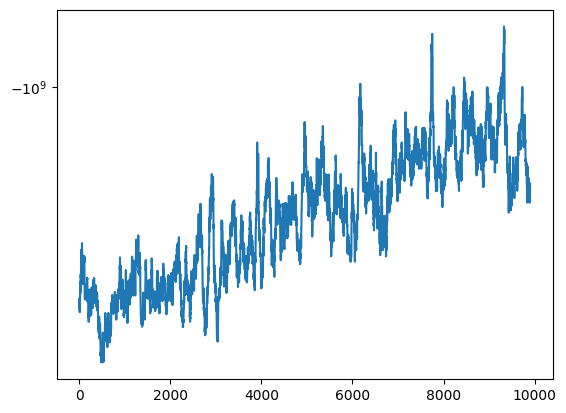

In [75]:
from numpy.lib.stride_tricks import sliding_window_view
plt.plot(sliding_window_view(elbos, 100).mean(axis=1))
plt.yscale('symlog')

In [76]:
last_layer_vi.eval()
with torch.no_grad():
    X_test = torch.linspace(-10,10, 300).unsqueeze(1)
    features_test = lli_net.get_ll_embedd(X_test)
    preds_samples = []
    preds_stds = []
    for _ in range(100):
        preds = last_layer_vi.forward_sample(features_test)
        preds_samples.append(preds.squeeze())
    preds_samples = torch.stack(preds_samples)
    mean_pred = preds_samples.mean(dim=0)
    std_pred = preds_samples.std(dim=0)

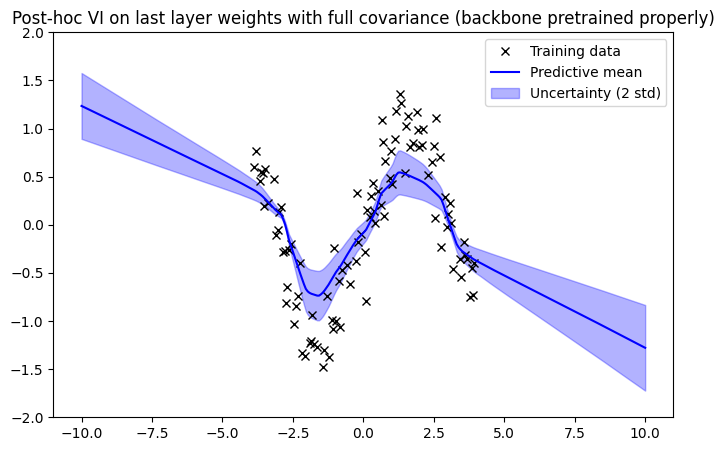

In [77]:
plt.figure(figsize=(8,5))
plt.ylim(-2,2)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), mean_pred.numpy(), 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 mean_pred.numpy() - 2 * std_pred.numpy(),
                mean_pred.numpy() + 2 * std_pred.numpy(),
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance (backbone pretrained properly)")
plt.show()
